In [1]:
import os
NUM_THREADS = "12"
os.environ["OMP_NUM_THREADS"] = NUM_THREADS # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = NUM_THREADS # export OPENBLAS_NUM_THREADS=4
os.environ["MKL_NUM_THREADS"] = NUM_THREADS # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = NUM_THREADS # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = NUM_THREADS # export NUMEXPR_NUM_THREADS=6
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py as h5
import tqdm.notebook as tqdm

from lib import *

dx = 0.004149377593360996
dt_imp = 0.00023956442704963727
dt = 4.791288540992745e-06
times.size : 31351
times_imp.size : 628
saved_times.size : 628


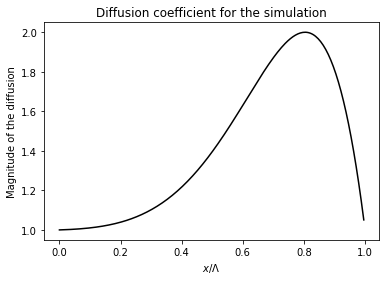

In [2]:
# Spatial discretisation
n=241
Lambda=1
x=Lambda*(np.arange(n)/n)
dx=x[1]-x[0]

# Diffusion coefficient
A = np.sin(x*np.pi)*(1+x)**8
D = A/A.max() + 1
bDx0 = lambda t : 1
bDxL = lambda t : 1
T_diff = (Lambda/2)**2/D.max()

Lx = 0.1*Lambda
scale = Lx/dx
Lt = Lx**2/(np.sqrt(3)*D[0])
dt_imp = Lt/scale
sub_sampling = 50
dt = dt_imp/sub_sampling

print("dx = {}".format(dx))
print("dt_imp = {}".format(dt_imp))
print("dt = {}".format(dt))
if dt>((0.6*dx**2)/D.max()):
    print("WARNING: CFL condition not satisfied")

# Time window
t_end = 1.2*T_diff + dt_imp
t_end = (t_end//dt_imp)*dt_imp
times = np.arange(0,t_end+dt,dt)
times_imp = times[::sub_sampling]
saved_times = times[::sub_sampling]
print("times.size : {}".format(times.size))
print("times_imp.size : {}".format(times_imp.size))
print("saved_times.size : {}".format(saved_times.size))

# Initial state
c0 = np.ones(n)

# Creates the boundary conditions for the forward and the TL models
bc = 'neumann'
bcx0 = lambda t : 0
bcxL = lambda t : 0

bx0 = lambda t : (bcx0(t), bDx0(t))
bxL = lambda t : (bcxL(t), bDxL(t))

model = Diffusion(x=x, D=D, bc=bc, bx0=bx0, bxL=bxL, time_scheme='backward_euler')

plot = True

if plot:
    plt.figure()
    plt.plot(model.x, model.D, c='k')
    plt.xlabel("$x/\Lambda$")
    plt.ylabel("Magnitude of the diffusion")
    plt.title("Diffusion coefficient for the simulation");

In [3]:
V0 = 1
VL = 4

Lt0 = lambda t : Lt
LtL = lambda t : Lt

Vt0 = lambda t : V0
VtL = lambda t : VL

temporal_variances = np.array([[Vt0(t), VtL(t)] for t in times_imp])
temporal_scales = np.array([[Lt0(t), LtL(t)] for t in times_imp])

spatial_variances=np.linspace(V0, VL, n)
spatial_scales=np.zeros(n)+Lx

In [4]:
rng = np.random.default_rng()

max_steps = 20
time_window = np.linspace(0,0.5,max_steps)

homogeneous_diff = Diffusion(x=x, D=(Lx**2/2)*np.ones(n), bc=bc, bx0=bx0, bxL=bxL, time_scheme='backward_euler')

Ne = 6400
ensemble = np.zeros((Ne,n))

for i in tqdm.tqdm(range(Ne)):
    white_sample = rng.standard_normal(n)
    ensemble[i,:] = homogeneous_diff.forecast(time_window, white_sample, saved_times=time_window[-1])[time_window[-1]]

var = np.mean(ensemble**2, axis=0)
ensemble = ensemble/np.sqrt(var)

  0%|          | 0/6400 [00:00<?, ?it/s]

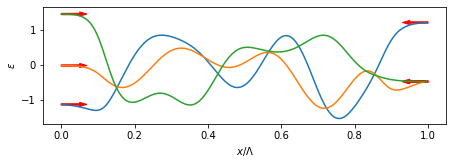

In [5]:
plt.figure(figsize=(6.4,2.4))
plt.plot(x, ensemble[0])
plt.arrow(0, ensemble[0][0], +0.05, 0, width=0.04, color='r', head_length=0.02, label='Boundary condition')
plt.arrow(1, ensemble[0][-1], -0.05, 0, width=0.04, color='r', head_length=0.02)
plt.plot(x, ensemble[1])
plt.arrow(0, ensemble[1][0], +0.05, 0, width=0.04, color='r', head_length=0.02)
plt.arrow(1, ensemble[1][-1], -0.05, 0, width=0.04, color='r', head_length=0.02)
plt.plot(x, ensemble[2])
plt.arrow(0, ensemble[2][0], +0.05, 0, width=0.04, color='r', head_length=0.02)
plt.arrow(1, ensemble[2][-1], -0.05, 0, width=0.04, color='r', head_length=0.02)
#plt.title("Normalized initial error samples with flat derivative on the boundaries")
plt.ylabel("$\epsilon$")
plt.xlabel("$x/\Lambda$")
plt.tight_layout()
plt.savefig("../figures/neumann-initial-error-samples.pdf")

g = np.mean(np.array([homogeneous_diff.derivative(error, dx)**2 for error in ensemble]), axis=0)
s = 1/g

ensemble = ensemble*np.sqrt(spatial_variances)

var = np.mean(ensemble**2, axis=0)

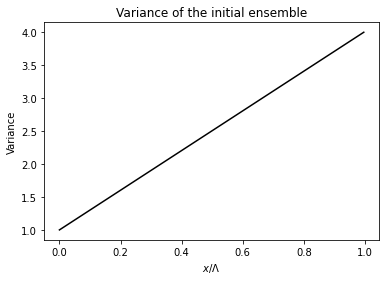

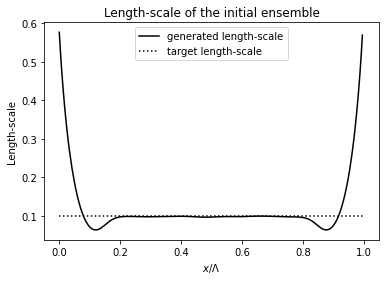

In [6]:
plt.figure()
plt.plot(x, var, c='k')
plt.title("Variance of the initial ensemble")
plt.ylabel("Variance")
plt.xlabel("$x/\Lambda$")

plt.figure()
plt.plot(x, np.sqrt(s), c='k', label="generated length-scale")
plt.plot([0,1],[Lx,Lx], c='k', ls=':', label="target length-scale")
plt.title("Length-scale of the initial ensemble")
plt.ylabel("Length-scale")
plt.xlabel("$x/\Lambda$")
plt.legend()

In [7]:
class EnKFExperiment2(EnKFExperiment):
    def __init__(self,*args, **kwargs):
        super().__init__(*args, **kwargs) # Time scheme is set from Model.__init__()

    def run_ensemble(self, Ne, times, saved_times, initial_condition, bx0, bxL):
        ensemble_forecasts = {t : [] for t in saved_times}
        self._Ne = Ne
        self._model._bx0 = bx0
        self._model._bxL = bxL

        for k in tqdm.tqdm(range(Ne)):
            # 1. Create a boundary condition
            random_init_cond = self._boundary[k]
            init_cond = initial_condition + random_init_cond
            # 2. Forecast with the boundary condition
            traj = self._model.forecast(times, init_cond, saved_times=saved_times) 
            # 3. Feads the ensemble of traj
            for t in saved_times:
                ensemble_forecasts[t].append(traj[t])
            
        self._ensemble_forecasts = ensemble_forecasts

In [8]:
heterogeneous_enkf_experiment = EnKFExperiment2(model, ensemble)
heterogeneous_enkf_experiment.run_ensemble(Ne=Ne, times=times_imp, saved_times=saved_times, initial_condition=np.ones(n), bx0=bx0, bxL=bxL)

  0%|          | 0/6400 [00:00<?, ?it/s]

In [9]:
class DiffusionPKF(Diffusion):

    def __init__(self,*args, **kwargs):
        super().__init__(*args, **kwargs) # Time scheme is set from Model.__init__()
    
    def trend(self, t, state, matrix_computation=False):
        """ Trend of the dynamics """

        dstate = np.zeros(state.shape)
        dc = dstate[0]
        dV_c = dstate[1]
        dg_c_xx = dstate[2]

        # Load physical functions from state
        c = state[0]
        V_c = state[1]
        g_c_xx = state[2]

        # Alias for constant functions
        D = self._D

        # Format boundary conditions
        bc_D = (self._bx0(t)[3], self._bxL(t)[3])
        if self._bc == 'dirichlet':
            bc_c = (self._bx0(t)[0],self._bxL(t)[0])
            bc_V_c = (self._bx0(t)[1],self._bxL(t)[1])
            bc_g_c_xx = (self._bx0(t)[2],self._bxL(t)[2])
        elif self._bc == 'neumann':
            bc_c = (c[1]-2*self._dx*self._bx0(t)[0], c[-2]+2*self._dx*self._bxL(t)[0])
            bc_V_c = (V_c[1]-2*self._dx*self._bx0(t)[1], V_c[-2]+2*self._dx*self._bxL(t)[1])
            bc_g_c_xx = (self._bx0(t)[2],self._bxL(t)[2]) # Dirichlet boundary condition on the metric g
        else:
            bc_c = None
            bc_V_c = None
            bc_g_c_xx = None

        # Compute derivative
        DD_x_o1 = self.derivative(D, self._dx, bc=bc_D)
        DD_x_o2 = self.derivative(D, self._dx, order=2, bc=bc_D)
        Dc_x_o1 = self.derivative(c, self._dx, bc=bc_c)
        Dc_x_o2 = self.derivative(c, self._dx, order=2, bc=bc_c)
        DV_c_x_o1 = self.derivative(V_c, self._dx, bc=bc_V_c)
        DV_c_x_o2 = self.derivative(V_c, self._dx, order=2, bc=bc_V_c)
        Dg_c_xx_x_o1 = self.derivative(g_c_xx, self._dx, bc=bc_g_c_xx)
        Dg_c_xx_x_o2 = self.derivative(g_c_xx, self._dx, order=2, bc=bc_g_c_xx)

        # Implementation of the trend
        dc[:] = D*Dc_x_o2 + DD_x_o1*Dc_x_o1
        dV_c[:] = -D*DV_c_x_o1**2/(2*V_c) + D*DV_c_x_o2 - 2*D*V_c*g_c_xx + DD_x_o1*DV_c_x_o1
        dg_c_xx[:] = -4*D*g_c_xx**2 + D*Dg_c_xx_x_o2 + 2*D*g_c_xx*DV_c_x_o2/V_c + D*DV_c_x_o1*Dg_c_xx_x_o1/V_c - 2*D*g_c_xx*DV_c_x_o1**2/V_c**2 + 2*g_c_xx*DD_x_o2 + 2*DD_x_o1*Dg_c_xx_x_o1 + 2*g_c_xx*DD_x_o1*DV_c_x_o1/V_c

        return dstate

In [10]:
pkf_bx0 = lambda t : (bcx0(t), 0, 0, bDx0(t))
pkf_bxL = lambda t : (bcxL(t), 0, 0, bDxL(t))

pkf_model = DiffusionPKF(x=x, D=D, bc=bc, bx0=pkf_bx0, bxL=pkf_bxL, time_scheme='rk4')

pkf_state0 = np.zeros((3,n))
pkf_state0[0][:] = 1
pkf_state0[1][:] = spatial_variances
pkf_state0[2][:] = g

pkf_traj = pkf_model.forecast(times, pkf_state0, saved_times=saved_times)

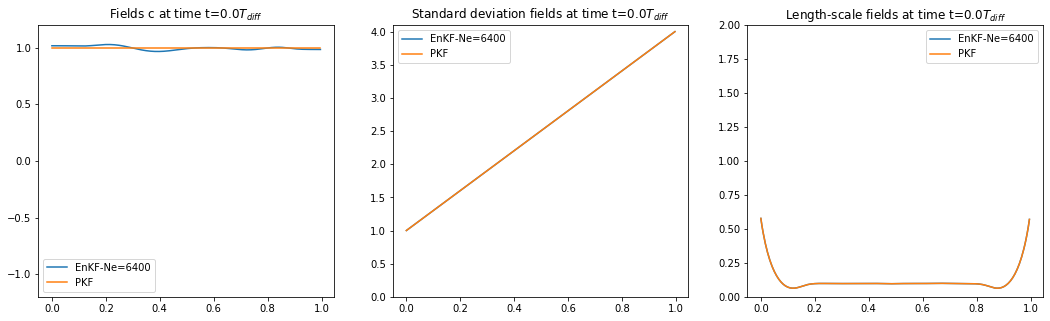

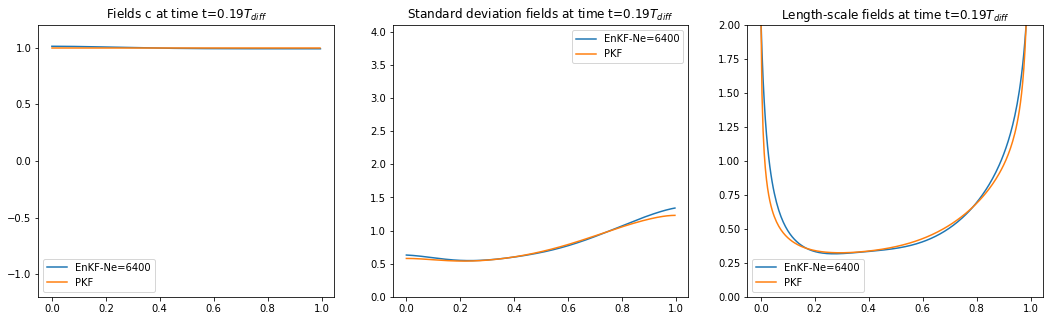

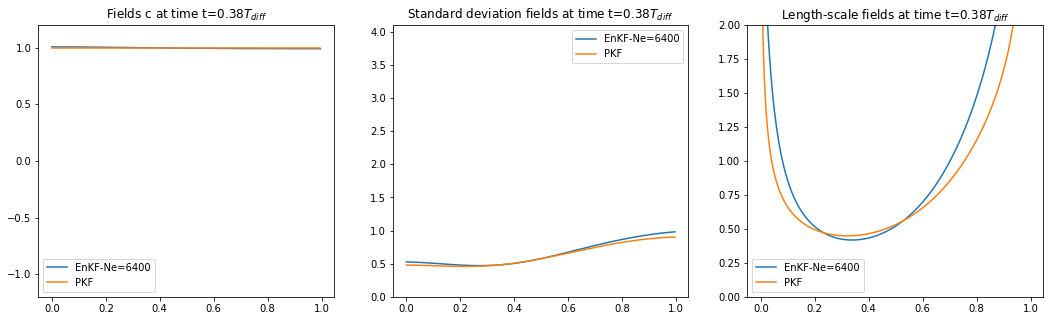

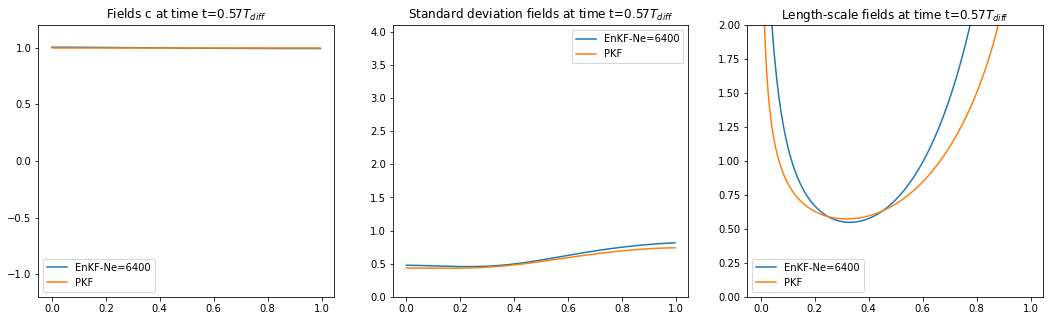

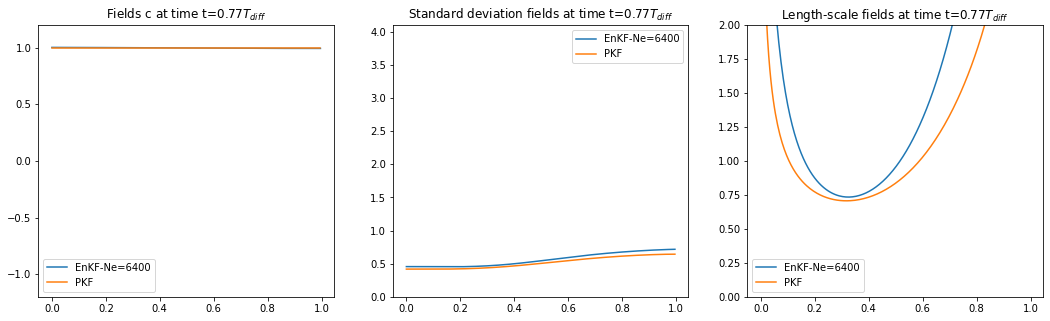

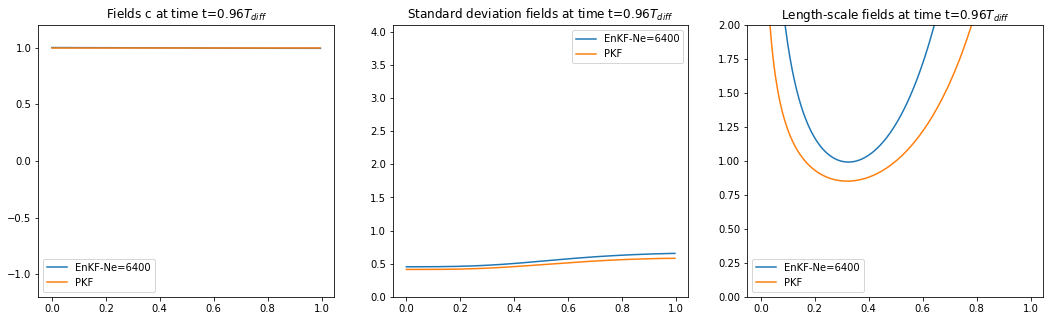

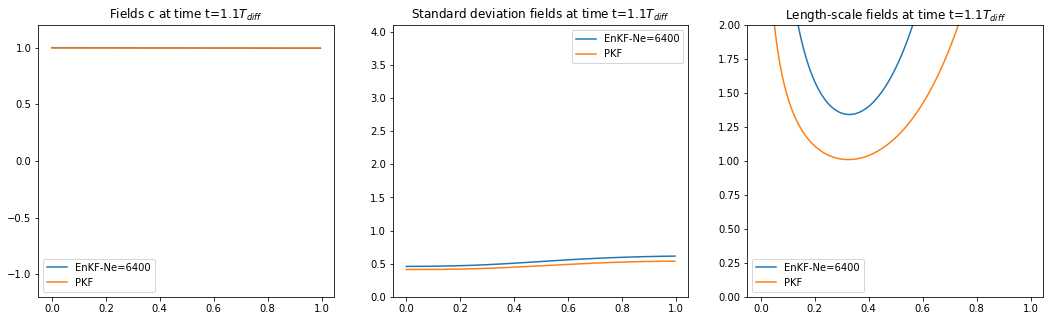

In [11]:
def plot_compare_at_t(t):
    plt.figure(figsize=(18,5))

    plt.subplot(131)
    plt.plot(model._x, heterogeneous_enkf_experiment.mean[t], label='EnKF-Ne={}'.format(heterogeneous_enkf_experiment.Ne))
    plt.plot(model._x, pkf_traj[t][0], label='PKF')
    plt.ylim(-1.2,1.2)
    plt.title(f"Fields c at time t={t/T_diff:1.2}"+"$T_{diff}$")
    plt.legend()

    plt.subplot(132)
    plt.plot(model._x, heterogeneous_enkf_experiment.variances[t], label='EnKF-Ne={}'.format(heterogeneous_enkf_experiment.Ne))
    plt.plot(model._x, pkf_traj[t][1], label='PKF')
    plt.ylim(0,4.1)
    plt.title(f"Standard deviation fields at time t={t/T_diff:1.2}"+"$T_{diff}$")
    plt.legend()

    plt.subplot(133)
    plt.plot(model.x, heterogeneous_enkf_experiment.length_scales[t],label=f'EnKF-Ne={heterogeneous_enkf_experiment.Ne}')
    plt.plot(model.x, np.sqrt(1/pkf_traj[t][2]),label='PKF')
    plt.ylim(0,2)
    plt.title(f"Length-scale fields at time t={t/T_diff:1.2}"+'$T_{diff}$')
    plt.legend()

if plot:
    for t in saved_times[::100]:
        plot_compare_at_t(t)
        plt.show()

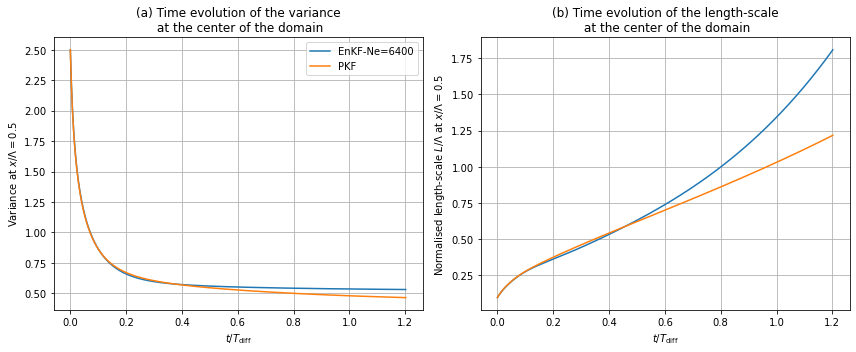

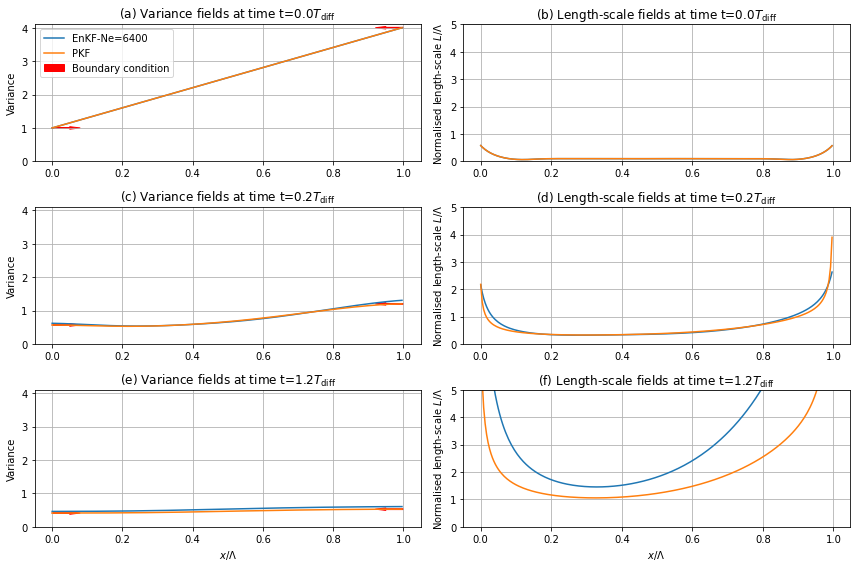

In [12]:
if plot:
    plt.figure(figsize=(12,5))

    plt.subplot(121)
    plt.plot(saved_times/T_diff, [heterogeneous_enkf_experiment.variances[t][120] for t in saved_times], label='EnKF-Ne={}'.format(heterogeneous_enkf_experiment.Ne))
    plt.plot(saved_times/T_diff, [pkf_traj[t][1][120] for t in saved_times], label='PKF')
    plt.title('(a) Time evolution of the variance\n at the center of the domain')
    plt.xlabel('$t/T_{\mathrm{diff}}$')
    plt.ylabel('Variance at $x/\Lambda=0.5 $')
    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.plot(saved_times/T_diff, [heterogeneous_enkf_experiment.length_scales[t][120] for t in saved_times], label='EnKF-Ne={}'.format(heterogeneous_enkf_experiment.Ne))
    plt.plot(saved_times/T_diff, [np.sqrt(1/pkf_traj[t][2][120]) for t in saved_times], label='PKF')
    plt.title('(b) Time evolution of the length-scale\n at the center of the domain')
    plt.xlabel('$t/T_{\mathrm{diff}}$')
    plt.ylabel('Normalised length-scale $L/\Lambda$ at $x/\Lambda=0.5 $')
    plt.grid()

    plt.tight_layout()

    plt.savefig('../figures/PKF-heterogeneous-diffusion-neumann-timeseries.pdf')


plot_times = [0, 105, -1]
letters = 'abcdef'

if plot:
    plt.figure(figsize=(12,8))

    for i in range(3):
        index = plot_times[i]
        plt.subplot(321 + 2*i)
        plt.plot(model._x, heterogeneous_enkf_experiment.variances[saved_times[index]], label='EnKF-Ne={}'.format(heterogeneous_enkf_experiment.Ne))
        plt.plot(model._x, pkf_traj[saved_times[index]][1], label='PKF')
        plt.arrow(0, pkf_traj[saved_times[index]][1][0], +0.05, 0, width=0.025, color='r', head_length=0.03, label='Boundary condition')
        plt.arrow(1, pkf_traj[saved_times[index]][1][-1], -0.05, 0, width=0.025, color='r', head_length=0.03)
        plt.ylim(0,4.1)
        plt.title("("+letters[2*i]+")"+f" Variance fields at time t={saved_times[index]/T_diff:1.2}"+"$T_{\mathrm{diff}}$")
        plt.ylabel('Variance')
        if i==0:
            plt.legend()
        if i==2:
            plt.xlabel("$x/\Lambda$")
        plt.grid()

        plt.subplot(322 + 2*i)
        plt.plot(model.x, heterogeneous_enkf_experiment.length_scales[saved_times[index]],label=f'EnKF-Ne={heterogeneous_enkf_experiment.Ne}')
        plt.plot(model.x, np.sqrt(1/pkf_traj[saved_times[index]][2]),label='PKF')
        plt.ylim(0,5)
        plt.title("("+letters[2*i+1]+")"+f" Length-scale fields at time t={saved_times[index]/T_diff:1.2}"+'$T_{\mathrm{diff}}$')
        plt.ylabel('Normalised length-scale $L/\Lambda$')
        if i==2:
            plt.xlabel("$x/\Lambda$")
        plt.grid()

    plt.tight_layout()
    plt.savefig('../figures/PKF-heterogeneous-diffusion-neumann-time-comparison.pdf')

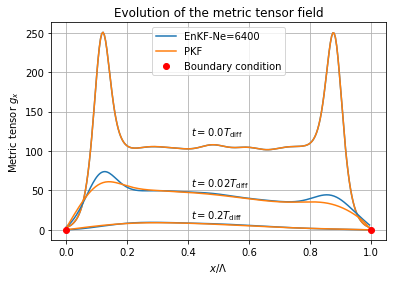

In [13]:
plot_times = [0, 10, 105]
if plot:
    plt.figure()
    for i in plot_times:
        if i==0:
            plt.plot(x, heterogeneous_enkf_experiment.metrics[saved_times[i]], c='tab:blue', label='EnKF-Ne={}'.format(heterogeneous_enkf_experiment.Ne))
            plt.plot(x, pkf_traj[saved_times[i]][2], c='tab:orange', label='PKF')
        else:
            plt.plot(x, heterogeneous_enkf_experiment.metrics[saved_times[i]], c='tab:blue')
            plt.plot(x, pkf_traj[saved_times[i]][2], c='tab:orange')
    plt.plot(0, 0, 'ro', label='Boundary condition')
    plt.plot(1, 0, 'ro')
    plt.text(0.41,120, f'$t={saved_times[plot_times[0]]/T_diff:1.2}$'+'$T_{\mathrm{diff}}$')
    plt.text(0.41,55, f'$t={saved_times[plot_times[1]]/T_diff:1.1}$'+'$T_{\mathrm{diff}}$')
    plt.text(0.41,15, f'$t={saved_times[plot_times[2]]/T_diff:1.2}$'+'$T_{\mathrm{diff}}$')
    plt.title("Evolution of the metric tensor field")
    plt.ylabel('Metric tensor $g_x$')
    plt.xlabel("$x/\Lambda$")
    plt.legend()
    plt.grid()

    plt.savefig('../figures/PKF-heterogeneous-diffusion-neumann-metrics.pdf')